# DeepFashion Dataset
a notebook to explore the DeepFashion dataset in order to prepare a `Dataset` class and `Dataloader` 

Note that the data used for Text2Human project was processed vs the original DeepFashion-MultiModal thus we might want to use this dataset, as the images are already aligned


In [ ]:
!jt -t onedork -cellw 90% -T

In [2]:
%load_ext autoreload
%autoreload 2

import os
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
from tqdm.notebook import tqdm
import pandas as pd
from glob import glob as Glob
import json
%matplotlib inline

!which python

/bin/bash: /home/guy/anaconda3/envs/dis_ir/lib/libtinfo.so.6: no version information available (required by /bin/bash)
/home/guy/anaconda3/envs/dis_ir/bin/python


# Datasets Exploration and preprocessing

## CelebA
this is the dataset considered as a baseline

In [ ]:
if os.uname()[1]=='guy-x':
    clba_path = '/home/guy/sd1tb/datasets/CelebA/celeba/img_align_celeba'

else:   # assuming gpu15
    clba_path = '/data/users/gkoren2/datasets/celeba/celeba/img_align_celeba'   # gpu15

print(f"assuming we're on {os.uname()[1]} so data is in {clba_path}")

imgs_filenames=os.listdir(clba_path)
len(imgs_filenames)

In [ ]:
# extract image sizes and make sure they all at sime size
imsz = [Image.open(os.path.join(clba_path,im)).size for im in imgs_filenames]
np.all([s==imsz[0] for s in imsz])

Lets check the alignment by displaying the average of the images

In [ ]:
img_indxs = [i for i in range(1000)]
avg_img = np.zeros_like(Image.open(os.path.join(clba_path,imgs_filenames[0])),dtype=np.float64)
for i,idx in enumerate(img_indxs):
    img=Image.open(os.path.join(clba_path,imgs_filenames[idx]))
    avg_img+=np.asarray(img)
avg_img = avg_img/len(img_indxs)
Image.fromarray(np.uint8(avg_img))

ok, we see that the images are pretty much aligned. this is something that should predict the successfulness of the VAE. 

In [ ]:
# to make a gif from the images:
img_indxs = [i for i in range(1000)]
imgs = (Image.open(os.path.join(clba_path,imgs_filenames[i])) for i in img_indxs)
img = next(imgs)  # extract first image from iterator
img.save(fp='celeba.gif', format='GIF', append_images=imgs,save_all=True, duration=20, loop=0)

Lets import the dataset as it is done in the VAE s.t. we understand how to prepare `DeepFashion` dataset

In [ ]:
from torchvision.datasets import CelebA
import torch.utils.data as data
from torchvision import transforms as T
# clba_path = '/data/users/gkoren2/datasets/celeba/'   # gpu15
clba_path = '/home/guy/sd1tb/datasets/CelebA/'
patch_size=256
trn_tfms = T.Compose([      # copied from dataset.py 
    T.RandomHorizontalFlip(),
    T.CenterCrop(148),
    T.Resize(patch_size),
    T.ToTensor(),
    ])

clba = CelebA(clba_path, split='train',transform=trn_tfms,download=False)

dir(clba)


In [ ]:
getattr(clba,'collate_fn',None)

In [ ]:
clba_loader = data.DataLoader(clba,batch_size=10,num_workers=0,shuffle=False)
clba_batch=next(iter(clba_loader))

In [ ]:
print(clba_batch[0].shape)       # the images tensor
print(clba_batch[1].shape)       # the labels (attributes) tensor


In [ ]:
print(len(clba.attr_names))
clba.attr_names

In [ ]:
clba_batch[0].std()

it looks like the only normalization they have applied is scaling s.t. the value of the pixels are in [0,1]. they havent normalized it to `mean=0 , stdev=1`

In [ ]:
T.ToPILImage()(clba_batch[0][1])

In [ ]:
clba_batch[1][0].shape

In [ ]:
clba_batch[1][0]

## DeepFashion-MultiModal

In [ ]:
dfmm_path = '/home/guy/sd1tb/datasets/deep_fashion/DeepFashion-MultiModal/images'
imgs_filenames=os.listdir(dfmm_path)
len(imgs_filenames)


In [ ]:
imsz = [Image.open(os.path.join(dfmm_path,im)).size for im in imgs_filenames]
imgs = [Image.open(os.path.join(dfmm_path,im)) for im in imgs_filenames[100:110]]
# plt.imshow(img)

In [ ]:
np.all([s==imsz[0] for s in imsz])

In [ ]:
[s for s in imsz if s != imsz[0] ]

In [ ]:
df=pd.DataFrame(imsz,columns=['x','y'])
df['new_col'] = list(zip(df.x, df.y))
df.head()

In [ ]:
df.new_col.value_counts()

In [ ]:
# resize the images with a limit on each axis size, while maintaining aspect ratio
size=(256,256)
[i.thumbnail(size) for i in imgs]
[im.size for im in imgs]

In [ ]:
[im.size for im in imgs]

## Text2Human Processed dataset

In [ ]:
t2h_path = '/home/guy/sd1tb/datasets/deep_fashion/Text2Human/train_images'
imgs_filenames=os.listdir(t2h_path)
len(imgs_filenames)


In [ ]:
# extract image sizes and make sure they all at sime size
t2h_imsz = [Image.open(os.path.join(t2h_path,im)).size for im in imgs_filenames]
np.all([s==t2h_imsz[0] for s in t2h_imsz])

In [ ]:
t2h_imsz[0]

In [ ]:
imgs = [Image.open(os.path.join(t2h_path,im)) for im in imgs_filenames[:20]]


In [ ]:
size

In [ ]:
size=(256,256)
imgs_tn=imgs.copy()
[i.thumbnail(size) for i in imgs_tn]
image_grid(imgs_tn,4,5)

## DeepFashion - Fashion Synthesis Benchmark

In [ ]:
import h5py

In [ ]:
f = h5py.File('/home/guy/sd1tb/datasets/deep_fashion/G2.h5','r')
for k in f.keys():
    print(k)
    print(type(f[k]))

In [ ]:
b=f['b_']
for k in b.keys():
    print(k)

## DeepFashion In-Shop Clothes Retrieval

- Images (Img/img.zip):   52,712 in-shop clothes images (~200,000 cross-pose/scale pairs).
    - Images are centered and resized to 256*256;
    - The aspect ratios of original images are kept unchanged
- Bounding Box Annotations (Anno/list_bbox_inshop.txt)
- Fashion Landmark Annotations (Anno/list_landmarks_inshop.txt)
- Item Annotations (Anno/list_item_inshop.txt)
- Description Annotations (Anno/list_description_inshop.json)
- Attribute Annotations (Anno/attributes/list_attr_cloth.txt & Anno/attributes/list_attr_items.txt & Anno/attributes/list_color_cloth.txt)
- Segmentation Mask Annotations (Anno/segmentation/DeepFashion_instances_train.json & Anno/segmentation/DeepFashion_instances_query.json & Anno/segmentation/DeepFashion_instances_gallery.json)
- Dense Pose Annotations (Anno/densepose/img_iuv.zip)
- Evaluation Partitions (Eval/list_eval_partition.txt)


In [ ]:
if os.uname()[1]=='guy-x':
    dataset_path = '/home/guy/sd1tb/datasets/deep_fashion/DeepFashion/In-shop Clothes Retrieval Benchmark'
else:   # assuming gpu15
    dataset_path = '/data/users/gkoren2/datasets/DeepFashion/In-shop-Clothes-Retrieval/In-shop Clothes Retrieval Benchmark' # gpu15

print(f"assuming we're on {os.uname()[1]} so data is in {dataset_path}")

# os.listdir(dataset_path)
!tree '{dataset_path}' -L 3

### Exploration

#### Annotations

In [ ]:
anno_filename = os.path.join(dataset_path,'Anno','list_item_inshop.txt')
with open(anno_filename,'r') as f:
    item_list=f.read().splitlines()

len(item_list)

In [ ]:
item_list[:10]

In [ ]:
anno_filename = os.path.join(dataset_path,'Anno','list_description_inshop.json')
with open(anno_filename,'r') as f:
    item_desc = json.load(f)
desc_df=pd.DataFrame(item_desc)

In [ ]:
desc_df.head()

In [ ]:
desc_df.item.value_counts()

In [ ]:
desc_df.loc[desc_df['item']=='id_00000001',:]

In [ ]:
anno_filename = os.path.join(dataset_path,'Anno','attributes','list_attr_cloth.txt')
with open(anno_filename,'r') as f:
    attr_cloth=f.read().splitlines()
attr_cloth = attr_cloth[2:]
len(attr_cloth)

In [ ]:
attr_cloth[:10]

In [ ]:
anno_filename = os.path.join(dataset_path,'Anno','attributes','list_attr_items.txt')
with open(anno_filename,'r') as f:
    attr_items=f.read().splitlines()
attr_items=attr_items[2:]
attr_items=[i.split() for i in attr_items]
attr_items = {i[0]:[int(int(a)>0) for a in i[1:]] for i in attr_items}
len(attr_items)

In [ ]:
print(len(attr_items['id_00000013']))
attr_items['id_00000013']

Notes:
1. The order of attribute labels accords with the order of attribute names;
2. In attribute labels, "1" represents positive while "-1" represents negative, '0' represents unknown;
3. Attribute prediction is treated as a multi-label tagging problem.


In [ ]:
attr_item_desc={i[0]:[attr_cloth[ai] for ai in range(len(attr_cloth)) if i[ai+1]=='1'] for i in attr_items}

In [ ]:
attr_item_desc['id_00000013']

In [ ]:
anno_filename = os.path.join(dataset_path,'Anno','attributes','list_color_cloth.txt')
with open(anno_filename,'r') as f:
    color_cloth=f.read().splitlines()

len(color_cloth)

In [ ]:
color_cloth[:10]

#### Eval partitions

In [ ]:
eval_part_filename = os.path.join(dataset_path,'Eval','list_eval_partition.txt')
with open(eval_part_filename,'r') as f:
    eval_part_list=f.read().splitlines()
eval_part_list=eval_part_list[2:]
eval_part_list=[i.split() for i in eval_part_list]
eval_part_list = {i[1]:i[2] for i in eval_part_list}


In [ ]:
pd.DataFrame(eval_part_list.values()).value_counts()

In [ ]:
epl0=eval_part_list[2]
epl0.split()

#### Images

##### explore

In [ ]:
! tree "{os.path.join(dataset_path,'Img/img')}" -L 2

In [ ]:
img_fn=[i for i in Glob(f'{dataset_path}/Img/**/*.jpg',recursive=True)] #  if 'side' in i]
len(img_fn)

In [ ]:
# base name
img_bn=[s.split('img')[1] for s in img_fn]
len(img_bn)

In [ ]:
[f for f in img_fn if 'id_00003321' in f]

In [ ]:
! tree "{os.path.join(os.path.dirname(dataset_path),'img_highres')}" -L 2

In [ ]:
img_hres_fn = [i for i in Glob(f"{os.path.join(os.path.dirname(dataset_path),'img_highres')}/**/*.jpg",recursive=True)]
len(img_hres_fn)

In [ ]:
img_hres_fn[:10]

In [ ]:
img_hres_bn=[s.split('img_highres')[1] for s in img_hres_fn]
len(img_hres_bn)

In [ ]:
# comapre the names - make sure we have exact copy of each image as highres
np.all(np.array(img_bn)==np.array(img_hres_bn))

In [ ]:
# lets see an image and its highres variant
img_id = 2345
img = Image.open(img_fn[img_id])
img_hres=Image.open(img_hres_fn[img_id])
print(f'{img.size} , {img_hres.size}')


we'll ignore the high res images. look only at the low res

##### get item images

In [ ]:
img_fn=[i for i in Glob(f'{dataset_path}/Img/**/*.jpg',recursive=True)] #  if 'side' in i]
img_hres_fn = [i for i in Glob(f"{os.path.join(os.path.dirname(dataset_path),'img_highres')}/**/*.jpg",recursive=True)]

In [ ]:
def get_item_images(item_id,hres=False):
    img_fns=img_hres_fn if hres else img_fn
    img_filenames = [f for f in img_fns if item_id in f]
    if len(img_filenames)==0:
        print(f'item {item_id} not found')
        return None
    else:
        imgs = {os.path.basename(f):Image.open(f) for f in img_filenames}
        print(f'found {len(imgs)} for item {item_id}')
        return imgs

In [ ]:
imgs = get_item_images('id_00000002',False)
imgs

In [ ]:
image_grid(list(imgs.values()),2,2)

In [ ]:
# get image stats
img_indxs = [i for i in range(len(img_fn))]
avg_img = np.zeros_like(Image.open(img_fn[0]),dtype=np.float64)
for i,idx in enumerate(img_indxs):
    img=Image.open(img_fn[idx])
    avg_img+=np.asarray(img)
avg_img = avg_img/len(img_indxs)
# Image.fromarray(np.uint8(avg_img))

In [ ]:
len(img_fn)

In [ ]:
img_fn[:10]

In [ ]:
img_fn[0].split('/')[-2]

In [ ]:
avg_img.shape

In [ ]:
avg_img[:,:,0].mean()/255

In [ ]:
ai1=avg_img.reshape([-1,3]).mean(axis=0)/255
ai1

In [ ]:
ai1-np.array([0.485, 0.456, 0.406])/np.array([0.229, 0.224, 0.225])

### Preprocess

In [ ]:
# TODO

## DeepFashion - Category and Attribute Prediction

- Images (Img/img.zip):  289,222 diverse clothes images. 
    - The long side of images are resized to 300;
    - The aspect ratios of original images are kept unchanged.
- Bounding Box Annotations (Anno/list_bbox.txt) bounding box labels. 
- Fashion Landmark Annotations (Anno/list_landmarks.txt) fashion landmark labels
- Category Annotations (Anno/list_category_cloth.txt & Anno/list_category_img.txt) clothing category labels. 
- Attribute Annotations (Anno/list_attr_cloth.txt & Anno/list_attr_img.txt) clothing attribute labels. 
- Evaluation Partitions (Eval/list_eval_partition.txt) image names for training, validation and testing set respectively.


In [3]:
if os.uname()[1]=='guy-x':
    dataset_path = '/home/guy/sd1tb/datasets/deep_fashion/DeepFashion/Category and Attribute Prediction Benchmark'
else:   # assuming gpu15
    dataset_path = '/data/users/gkoren2/datasets/DeepFashion/Category-and-Attribute-Prediction' # gpu15

print(f"assuming we're on {os.uname()[1]} so data is in {dataset_path}")

# os.listdir(dataset_path)
!tree '{dataset_path}' -L 2

assuming we're on guy-x so data is in /home/guy/sd1tb/datasets/deep_fashion/DeepFashion/Category and Attribute Prediction Benchmark
/bin/bash: /home/guy/anaconda3/envs/dis_ir/lib/libtinfo.so.6: no version information available (required by /bin/bash)
/home/guy/sd1tb/datasets/deep_fashion/DeepFashion/Category and Attribute Prediction Benchmark
├── Anno_coarse
│   ├── list_attr_cloth.txt
│   ├── list_attr_img.txt
│   ├── list_bbox.txt
│   ├── list_category_cloth.txt
│   ├── list_category_img.txt
│   └── list_landmarks.txt
├── Anno_fine
│   ├── list_attr_cloth.txt
│   ├── list_attr_img.txt
│   ├── list_category_cloth.txt
│   ├── test_attr.txt
│   ├── test_bbox.txt
│   ├── test_cate.txt
│   ├── test_landmarks.txt
│   ├── test.txt
│   ├── train_attr.txt
│   ├── train_bbox.txt
│   ├── train_cate.txt
│   ├── train_landmarks.txt
│   ├── train.txt
│   ├── val_attr.txt
│   ├── val_bbox.txt
│   ├── val_cate.txt
│   ├── val_landmarks.txt
│   └── val.txt
├── Eval
│   └── list_eval_partition.txt
├──

### Exploration

#### Annotations

##### Coarse

In [ ]:
anno_path = os.path.join(dataset_path,'Anno_coarse')

###### **list_attr_cloth.txt** and **list_attr_img.txt**

In [ ]:
anno_filename = os.path.join(anno_path,'list_attr_cloth.txt')
with open(anno_filename,'r') as f:
    attr_cloth=f.read().splitlines()
cols=attr_cloth[1].split()
attr_cloth=attr_cloth[2:]

attr_cloth_df = pd.DataFrame.from_dict({i: {cols[0]:attr_cloth[i].rstrip('  0123456789'),cols[1]:int(attr_cloth[i].split()[-1])} for i in range(len(attr_cloth))},orient='index')
attr_cloth_df.head()

it looks like there are 1000 attributes categorized to 5 groups (1 to 5). not clear what are these groups

In [ ]:
attr_cloth_df['attribute_type'].value_counts()

In [ ]:
anno_filename = os.path.join(anno_path,'list_attr_img.txt')
with open(anno_filename,'r') as f:
    attr_img=f.read().splitlines()
cols=attr_img[1].split()
attr_img=attr_img[2:]
attr_img=[i.split() for i in attr_img]
attr_img = {i[0]:[int(int(a)>0) for a in i[1:]] for i in attr_img}
len(attr_img)

In [ ]:
n_attr = len(attr_cloth_df['attribute_name'].values) 
attr_item_desc={i:[attr_cloth_df['attribute_name'].values[ai] for ai in range(n_attr) if attr_img[i][ai]==1] for i in tqdm(attr_img)}

In [ ]:
list(attr_img.keys())[0]

In [ ]:
attr_img['img/Sheer_Pleated-Front_Blouse/img_00000001.jpg']

In [ ]:
attr_item_desc['img/Sheer_Pleated-Front_Blouse/img_00000012.jpg']

###### **list_category_cloth.txt** and **list_category_img.txt**

In [ ]:
anno_filename = os.path.join(anno_path,'list_category_cloth.txt')
with open(anno_filename,'r') as f:
    cat_cloth=f.read().splitlines()
cols=cat_cloth[1].split()
cat_cloth=cat_cloth[2:]

cat_cloth_df = pd.DataFrame.from_dict({i: {cols[0]:cat_cloth[i].rstrip('  0123456789'),cols[1]:int(cat_cloth[i].split()[-1])} for i in range(len(cat_cloth))},orient='index')
cat_cloth_df.head()

In [ ]:
cat_cloth_df['category_type'].value_counts()

In [ ]:
anno_filename = os.path.join(anno_path,'list_category_img.txt')
with open(anno_filename,'r') as f:
    cat_img=f.read().splitlines()
cols=cat_img[1].split()
cat_img=cat_img[2:]
cat_img_df = pd.DataFrame.from_dict({i: {cols[0]:cat_img[i].split()[0],cols[1]:int(cat_img[i].split()[-1])} for i in range(len(cat_img))},orient='index')
cat_img_df['category_name']=cat_img_df['category_label'].map(cat_cloth_df['category_name'])
cat_img_df.head()

In [ ]:
len(cat_img_df['category_label'].value_counts())

In [ ]:
cat_img_df['category_name']=cat_img_df['category_label'].map(cat_cloth_df['category_name'])

In [ ]:
cat_img_df['image_name'].values

In [ ]:
n_cat = len(cat_cloth_df['category_name'].values) 
cat_item_desc={i:cat_cloth_df['category_name'] for i in tqdm(cat_img)}

###### **list_bbox.list**

In [ ]:
anno_filename = os.path.join(anno_path,'list_bbox.txt')
with open(anno_filename,'r') as f:
    bbox=f.read().splitlines()
cols=bbox[1].split()
bbox=bbox[2:]
bbox=[i.split() for i in bbox]
bbox = {i[0]:[int(a) for a in i[1:]] for i in bbox}
bbox = pd.DataFrame.from_dict(bbox,orient='index',columns=cols[1:])
# check that it is loaded ok
# bbox.loc['img/Sheer_Pleated-Front_Blouse/img_00000001.jpg']
print(len(bbox))
bbox.head()

##### Fine

In [ ]:
anno_path = os.path.join(dataset_path,'Anno_fine')
os.listdir(anno_path)

**list_attr_cloth.txt** and 

In [ ]:
anno_filename = os.path.join(anno_path,'list_attr_cloth.txt')
with open(anno_filename,'r') as f:
    fine_attr_cloth=f.read().splitlines()
cols=fine_attr_cloth[1].split()
fine_attr_cloth=fine_attr_cloth[2:]

fine_attr_cloth_df = pd.DataFrame.from_dict({i: {cols[0]:fine_attr_cloth[i].rstrip('  0123456789'),cols[1]:int(fine_attr_cloth[i].split()[-1])} for i in range(len(fine_attr_cloth))},orient='index')
fine_attr_cloth_df.head()

In [ ]:
len(fine_attr_cloth_df)

for some reason, in the fine annotation we have only 26 attributes (vs 1000 we had in the coarse)
and there are some attributes in the fine annotation that are not in the 1000 attributes of the coarse. lets see what are they:

In [ ]:
attr_diff=set(fine_attr_cloth_df['attribute_name'].values).difference(attr_cloth_df['attribute_name'].values)
attr_diff

#### Images

In [ ]:
img_fn=[i for i in Glob(f'{dataset_path}/Img/img/**/*.jpg',recursive=True)] #  if 'side' in i]
# img_hres_fn = [i for i in Glob(f"{os.path.join(dataset_path,'img_highres')}/**/*.jpg",recursive=True)]

print(len(img_fn))
# print(len(img_hres_fn))

In [ ]:
# 'img/Mid-Rise_-_Acid_Wash_Skinny_Jeans/img_00000010.jpg' in img_fn
np.any(['img/Mid-Rise_-_Acid_Wash_Skinny_Jeans/img_00000010.jpg' in i for i in img_fn])

In [ ]:
bbox.index[0]

In [ ]:
img_fn[0].split('Img/')[1]

In [ ]:
import cv2
def show_img_bbox(imgname):
    img=Image.open(imgname)
    img = np.array(img)
    bb = bbox.loc[imgname.split('Img/')[1]]
    img = cv2.rectangle(img,tuple(bb[:2]),tuple(bb[2:]),(255,0,0),2)
    return Image.fromarray(img)

def crop_img_bbox(imgname,size=256,value=(255,255,255)):
    img=Image.open(imgname)
    img = np.array(img)
    x1,y1,x2,y2 = bbox.loc[imgname.split('Img/')[1]] # x1 y1 x2 y2
    w=x2-x1
    h=y2-y1
    rsz = size/h if h>w else size/w
    w=int(w*rsz)
    h=int(h*rsz)
    new_img = cv2.resize(img[y1:y2,x1:x2],(w,h))
    new_img = cv2.copyMakeBorder(new_img,(size-h)//2,(size-h)//2,(size-w)//2,(size-w)//2,cv2.BORDER_CONSTANT,value = (255,255,255))
    new_img=Image.fromarray(new_img)    
    return new_img

In [ ]:
show_img_bbox(img_fn[151])

In [ ]:
crop_img_bbox(img_fn[151])

In [ ]:
img_fn[0]

In [ ]:
img_fn[0].split('Img/')[0]+'Img/preprocessed_'+img_fn[0].split('Img/')[1]

### Preprocess
The goal is to create a folder that is a duplicate of the original dataset in structure, but where the images are already preprocessed in order to save the time during training.
any deterministic operation that doesnt harm any future augmentation should be done in this stage 

It looks like its better working with the bounding box to make it cleaner for the model. 
I prefer to process the dataset offline to do the following:
- crop the image by the bounding box
- resize to (256,256) by doing the following:
    - the long dimension of the image is scaled to 256
    - the short dimension is scaled with this factor
    - padd the short dimension to 256 using white background
 
I will prepare the dataset with the same structure as the original dataset. s.t. I can use all the annotations (attributes) 

In [4]:
from deep_fashion_utils import *

In [5]:
# read images
img_fn=[i for i in Glob(f'{dataset_path}/Img/img/**/*.jpg',recursive=True)] #  if 'side' in i]
print(f'found {len(img_fn)} images, printing first 5:')
img_fn[:5]

found 289229 images, printing first 5:


['/home/guy/sd1tb/datasets/deep_fashion/DeepFashion/Category and Attribute Prediction Benchmark/Img/img/Free_Spirit_Muscle_Tee/img_00000034.jpg',
 '/home/guy/sd1tb/datasets/deep_fashion/DeepFashion/Category and Attribute Prediction Benchmark/Img/img/Free_Spirit_Muscle_Tee/img_00000039.jpg',
 '/home/guy/sd1tb/datasets/deep_fashion/DeepFashion/Category and Attribute Prediction Benchmark/Img/img/Free_Spirit_Muscle_Tee/img_00000045.jpg',
 '/home/guy/sd1tb/datasets/deep_fashion/DeepFashion/Category and Attribute Prediction Benchmark/Img/img/Free_Spirit_Muscle_Tee/img_00000055.jpg',
 '/home/guy/sd1tb/datasets/deep_fashion/DeepFashion/Category and Attribute Prediction Benchmark/Img/img/Free_Spirit_Muscle_Tee/img_00000037.jpg']

In [6]:
# reading the bounding boxes
bbox_path = os.path.join(dataset_path,'Anno_coarse','list_bbox.txt')
bbox_df=catp_read_bbox_to_df(bbox_path)
bbox_df.head()

,x_1,y_1,x_2,y_2
img/Sheer_Pleated-Front_Blouse/img_00000001.jpg,72,79,232,273
img/Sheer_Pleated-Front_Blouse/img_00000002.jpg,67,59,155,161
img/Sheer_Pleated-Front_Blouse/img_00000003.jpg,65,65,156,200
img/Sheer_Pleated-Front_Blouse/img_00000004.jpg,51,62,167,182
img/Sheer_Pleated-Front_Blouse/img_00000005.jpg,46,88,166,262


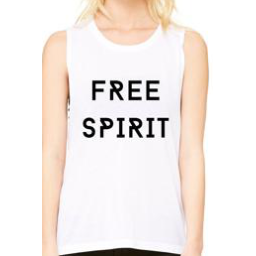

In [7]:
# test before batch processing
imgname=img_fn[15]
img=crop_img_bbox(imgname,bbox_df.loc[imgname.split('Img/')[1]])
# img=crop_img_bbox(imgname,None)
img

In [ ]:
# create dst folder
dst_folder = os.path.join(dataset_path,'Img','preprocessed_img') 
print(f'creating {dst_folder}')
os.makedirs(dst_folder)

# go over all images in the dataset and preprocess using the crop_img_bbox
n_missing_boxes=0
for img in tqdm(img_fn):
    dst_img_fn = img.split('Img/')[0]+'Img/preprocessed_'+img.split('Img/')[1]
    dst_img_folder = os.path.dirname(dst_img_fn)
    if not os.path.isdir(dst_img_folder):
        os.makedirs(dst_img_folder)
    try:
        bbox = bbox_df.loc[img.split('Img/')[1]]
    except KeyError:
        n_missing_boxes += 1
        print(f'{img}:{np.array(Image.open(img)).shape}')
#         bbox=None
        continue
    dst_img = crop_img_bbox(img,bbox)
    dst_img.save(dst_img_fn)

    
print(f'there are {n_missing_boxes} bboxes missing')

creating /home/guy/sd1tb/datasets/deep_fashion/DeepFashion/Category and Attribute Prediction Benchmark/Img/preprocessed_img


  0%|          | 0/289229 [00:00<?, ?it/s]

/home/guy/sd1tb/datasets/deep_fashion/DeepFashion/Category and Attribute Prediction Benchmark/Img/img/Buttoned_Collarless_Blouse/img_00000080.jpg:(300, 200)


In [ ]:
# debug: find the row with specific index value
bbox_df.loc[bbox_df.index.str.contains('Buttoned_Collarless_Blouse/img_00000081.jpg')]

# Preparing the dataset
The goal is to prepare a dataset class and dataloader that we can use to train the VAE.
we can use the code from the `Text2Human` repo

here's another [repo](https://github.com/ihciah/deep-fashion-retrieval) that uses the datasets.

and here's another repo from the authors of DeepFashion: [mmfashion](https://github.com/open-mmlab/mmfashion)
in that repo, look at the [In_shop.py](https://github.com/open-mmlab/mmfashion/blob/master/mmfashion/datasets/In_shop.py) file


In [ ]:
import os
from glob import glob as Glob
import numpy as np
import torch
import torch.utils.data as data
from torchvision.io import read_image
from torchvision import transforms as T

In [ ]:
if os.uname()[1]=='guy-x':
    dataset_path = '/home/guy/sd1tb/datasets/deep_fashion/DeepFashion/Category and Attribute Prediction Benchmark'
#     dataset_path = '/home/guy/sd1tb/datasets/deep_fashion/DeepFashion/In-shop Clothes Retrieval Benchmark'
else:   # assuming gpu15
    dataset_path = '/data/users/gkoren2/datasets/DeepFashion/Category-and-Attribute-Prediction' # gpu15
#     dataset_path = '/data/users/gkoren2/datasets/DeepFashion/In-shop-Clothes-Retrieval/In-shop Clothes Retrieval Benchmark' # gpu15

print(f"assuming we're on {os.uname()[1]} so data is in {dataset_path}")

img_fn=[i for i in Glob(f'{dataset_path}/Img/preprocessed_img/**/*.jpg',recursive=True)]      # Category-and-Attribute-Prediction
# img_fn=[i for i in Glob(f'{dataset_path}/Img/**/*.jpg',recursive=True)] #  In-shop-Clothes-Retrieval
img_fn[29540:29540+10]

In [ ]:
img_fn[29540:29540+10]

In [ ]:
[np.array(Image.open(f)).shape for f in img_fn[29540:29540+10]]

In [ ]:
Image.open(img_fn[29540])

In [ ]:
imsz={f.split('preprocessed_img/')[1]:Image.open(f).size for f in img_fn}

things we'll need to do:
- transform to tensor
- normalize the dataset

we wont do any further adjustments or augmentations at this stage.




In [ ]:
imsz

In [ ]:
imgname=img_fn[0]
crop_img_bbox(imgname,bbox.loc[imgname.split('Img/')[1]])

## Dataset Normalization
in order to normalize the dataset, we could either use the pytorch official normalization statistics as derived from ImageNet (see [this discussion](https://stackoverflow.com/questions/58151507/why-pytorch-officially-use-mean-0-485-0-456-0-406-and-std-0-229-0-224-0-2)):  
`mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])` 

but we might want to compute the statistics by ourselves as the images in this dataset are not that natural. they all have a clean background.
for that, lets define the dataset class without the normalization and then compute its stats

In [ ]:
trn_tfms = T.Compose([
#     T.ToPILImage(),
    #---------comment out data augmentation------
    # T.ColorJitter(brightness=(0.8,1.2), 
    # contrast=(0.8,1.2), 
    # saturation=(0.8,1.2), 
    # hue=0.25),
    # T.RandomAffine(5, translate=(0.01,0.1)),
    #---------------------------------------------
    T.ToTensor(),
    # T.Normalize(mean=[0.485, 0.456, 0.406], 
    #             std=[0.229, 0.224, 0.225]),
])

val_tfms = T.Compose([
#     T.ToPILImage(),
    T.ToTensor(),
    # T.Normalize(mean=[0.485, 0.456, 0.406], 
    #             std=[0.229, 0.224, 0.225]),
])



class DeepFashion(data.Dataset):
    """DeepFashion dataset."""

    def __init__(self, files, transform=None):
        self.files = files
        self.transform = transform

    def __len__(self):
        return len(self.files)

    def __getitem__(self, ix):
        fpath = self.files[ix]
#         clss = fname(parent(fpath))  # todo: read the label/attributes
        img = read_image(fpath)/255.0
        # return a dummy label at this stage as it doesnt matter
        return img,1

    def choose(self):
        return self[np.random.randint(len(self))]

    # def collate_fn(self, batch):
    #     imgs, classes = list(zip(*batch))
    #     if self.transform:
    #         imgs = [self.transform(img)[None] for img in imgs]
    #     classes = [torch.tensor([id2int[clss]]) for clss in classes]
    #     imgs, classes = [torch.cat(i).to(device) for i in [imgs, classes]]
    #     return imgs, classes

    def collate_fn(self, batch):
        imgs, classes = list(zip(*batch))
        if self.transform:
            imgs = [self.transform(img)[None] for img in imgs]
        return imgs


dataset = DeepFashion(img_fn,trn_tfms)
loader = data.DataLoader(dataset,batch_size=10,num_workers=0,shuffle=False)

In [ ]:
batch=next(iter(loader))
b,c,h,w=next(iter(loader))[0].shape
print(b,c,h,w)

In [ ]:
T.ToPILImage()(batch[0][1])


once we have the dataset defined we can compute the stats as follows ([reference](https://discuss.pytorch.org/t/computing-the-mean-and-std-of-dataset/34949))

In [ ]:
# get dataset statistics. to be used for normalizing the dataset
# h,w=next(iter(loader))[0].shape[2:]
mean = 0.0
for images, _ in tqdm(loader):
    batch_samples = images.size(0) 
    images = images.view(batch_samples, images.size(1), -1)
    mean += images.mean(2).sum(0)
mean = mean / len(loader.dataset)

var = 0.0
for images, _ in tqdm(loader):
    batch_samples = images.size(0)
    images = images.view(batch_samples, images.size(1), -1)
    var += ((images - mean.unsqueeze(1))**2).sum([0,2])
std = torch.sqrt(var / (len(loader.dataset)*h*w))


print(f'mean:{mean},std:{std}')

## Dataset Class definition
now that we have the dataset statistics we can create a dataset that normalizes appropriately.


In [ ]:
trn_tfms = T.Compose([
    T.ToPILImage(),
    T.Resize(256),
    T.ToTensor(),
    # T.Normalize(mean=[0.8323, 0.8108, 0.8040], 
    #             std=[0.2332, 0.2500, 0.2564]),
])

val_tfms = T.Compose([
    T.ToPILImage(),
    T.Resize(256),
    T.ToTensor(),
    # T.Normalize(mean=[0.8323, 0.8108, 0.8040], 
    #             std=[0.2332, 0.2500, 0.2564]),
])

class DeepFashion(data.Dataset):
    """DeepFashion dataset."""

    def __init__(self, dataset_path, split='train',transform=None):
        self.files=[i for i in Glob(f'{dataset_path}/Img/**/*.jpg',recursive=True)] 
        # read item attributes:
        # the attribute can be the cloth attribute or it can be viewing angle or type of item (based on the folder)
        # in the following example, we're taking the cloth attributes (463 attributes)
        anno_filename = os.path.join(dataset_path,'Anno','attributes','list_attr_items.txt')
        with open(anno_filename,'r') as f:
            attr_items=f.read().splitlines()
        attr_items=attr_items[2:]
        attr_items=[i.split() for i in attr_items]
        self.attr_items = {i[0]:[int(int(a)>0) for a in i[1:]] for i in attr_items}
        # get attributes names
        anno_filename = os.path.join(dataset_path,'Anno','attributes','list_attr_cloth.txt')
        with open(anno_filename,'r') as f:
            attr_cloth=f.read().splitlines()
        self.attr_names = attr_cloth[2:]

        # split the dataset and throw the irrelevant part
        train_fraction=0.8
        train_size = int(train_fraction* len(self.attr_items.keys()))

        if split=='train':
            self.files = self.files[:train_size]
        else:
            self.files = self.files[train_size:]

        self.transform = transform

    def __len__(self):
        return len(self.files)

    def __getitem__(self, ix):
        fpath = self.files[ix]
        lbl=self.attr_items[fpath.split('/')[-2]]
        img = read_image(fpath)/255.0
        return img,lbl

    def choose(self):
        return self[np.random.randint(len(self))]


    def collate_fn(self, batch):
        imgs, attrs = list(zip(*batch))
        if self.transform:
            imgs = [self.transform(img)[None] for img in imgs]
        else:
            imgs = [img[None] for img in imgs]
        attrs=[torch.tensor(a)[None] for a in attrs]
        imgs,attrs = [torch.cat(i) for i in [imgs,attrs]]
        return imgs,attrs

dataset = DeepFashion(dataset_path,'train')
loader = data.DataLoader(dataset,batch_size=10,num_workers=0,shuffle=False,collate_fn=dataset.collate_fn)

In [ ]:
dataset.files[:10]

In [ ]:
batch=next(iter(loader))
b,c,h,w=batch[0].shape
print(b,c,h,w)
print(batch[1].shape)

In [ ]:
T.ToPILImage()(batch[0][3])

In [ ]:
batch[1][0].shape

The following cell presents the InshopDataset as taken from ... (I dont remember)

In [ ]:
import os
import random

import numpy as np
import torch
import torch.nn.parallel
import torch.optim
import torch.utils.data
import torchvision.transforms as transforms
from PIL import Image
from torch.utils.data.dataset import Dataset

class InShopDataset(Dataset):
    CLASSES = None

    def __init__(self,
                 img_path,
                 img_file,
                 label_file,
                 id_file,
                 bbox_file,
                 landmark_file,
                 img_size,
                 roi_plane_size=7,
                 retrieve=False,
                 find_three=False):
        self.img_path = img_path
        # see https://stackoverflow.com/questions/58151507/why-pytorch-officially-use-mean-0-485-0-456-0-406-and-std-0-229-0-224-0-2
        normalize = transforms.Normalize(
            mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # these are imagenet statistics. is this correct for DeepFashion ?
        self.transform = transforms.Compose([
            transforms.RandomResizedCrop(img_size[0]),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            normalize,
        ])

        # read img names
        fp = open(img_file, 'r')
        self.img_list = [x.strip() for x in fp]

        # collect id
        self.ids = []
        id_fn = open(id_file).readlines()
        self.id2idx, self.idx2id = {}, {}
        for idx, line in enumerate(id_fn):
            img_id = int(line.strip('\n'))
            self.ids.append(img_id)
            self.idx2id[idx] = img_id

            if img_id not in self.id2idx:
                self.id2idx[img_id] = [idx]
            else:
                self.id2idx[img_id].append(idx)
        fp.close()

        # read labels
        self.labels = np.loadtxt(label_file, dtype=np.float32)

        self.img_size = img_size
        self.roi_plane_size = roi_plane_size

        # load bbox
        if bbox_file:
            self.with_bbox = True
            self.bboxes = np.loadtxt(bbox_file, usecols=(0, 1, 2, 3))
        else:
            self.with_bbox = False
            self.bboxes = None

        # load landmarks
        if landmark_file:
            self.landmarks = np.loadtxt(landmark_file)
        else:
            self.landmarks = None

        self.find_three = find_three

    def get_basic_item(self, idx):
        img = Image.open(os.path.join(self.img_path, self.img_list[idx]))
        img_id = self.ids[idx]
        width, height = img.size

        if self.with_bbox:
            bbox_cor = self.bboxes[idx]
            x1 = max(0, int(bbox_cor[0]) - 20)
            y1 = max(0, int(bbox_cor[1]) - 20)
            x2 = int(bbox_cor[2]) + 20
            y2 = int(bbox_cor[3]) + 20
            img = img.crop(box=(x1, y1, x2, y2))

        img.thumbnail(self.img_size, Image.ANTIALIAS)
        img = img.convert('RGB')

        label = torch.from_numpy(self.labels[idx])
        landmark = []
        # compute the shifted variety

        origin_landmark = self.landmarks[idx]
        for i, l in enumerate(origin_landmark):
            if i % 2 == 0:  # x
                l_x = max(0, l - x1)
                l_x = float(l_x) / width * self.roi_plane_size
                landmark.append(l_x)
            else:  # y
                l_y = max(0, l - y1)
                l_y = float(l_y) / height * self.roi_plane_size
                landmark.append(l_y)

        landmark = torch.from_numpy(np.array(landmark)).float()
        img = self.transform(img)
        data = {'img': img, 'landmark': landmark, 'id': img_id, 'attr': label}
        return data

    def get_three_items(self, idx):
        """return anchor, positive and negative
        """
        anchor_data = self.get_basic_item(idx)
        anchor_id = self.ids[idx]

        # get positive example
        pos_idxes = self.id2idx[anchor_id]
        if len(pos_idxes) == 1:  # just one item
            pos_data = anchor_data
        else:
            random_pos_idx = pos_idxes[random.randint(0, len(pos_idxes) - 1)]
            while random_pos_idx == idx:
                random_pos_idx = pos_idxes[random.randint(
                    0,
                    len(pos_idxes) - 1)]
            pos_data = self.get_basic_item(random_pos_idx)

        # get negative example
        id_len = len(self.ids)
        random_id = self.ids[random.randint(0, id_len - 1)]
        while random_id == anchor_id:
            random_id = self.ids[random.randint(0, id_len - 1)]
        neg_id = random_id
        neg_idxes = self.id2idx[neg_id]
        neg_idx = neg_idxes[random.randint(0, len(neg_idxes) - 1)]
        neg_data = self.get_basic_item(neg_idx)

        # create label for triplet loss
        triplet_pos_label = np.float32(1)
        triplet_neg_label = np.float32(-1)

        data = {
            'img': anchor_data['img'],
            'landmark': anchor_data['landmark'],
            'id': anchor_data['id'],
            'attr': anchor_data['attr'],
            'pos': pos_data['img'],
            'neg': neg_data['img'],
            'pos_lm': pos_data['landmark'],
            'neg_lm': neg_data['landmark'],
            'triplet_pos_label': triplet_pos_label,
            'triplet_neg_label': triplet_neg_label
        }
        return data

    def __getitem__(self, idx):
        if self.find_three:
            return self.get_three_items(idx)
        else:
            return self.get_basic_item(idx)

    def __len__(self):
        return len(self.img_list)